# Accuracy and Beyond
## Harris Dupre
## Data 612, Summer 2020

### Introduction

In this project we will attempt to measure the accuracy of three separate recommender system algorithms: singular value decomposition, user-based collaborative filtering, and item-based collaborative filtering.

This project will make use of the library scikit Surprise:
https://surprise.readthedocs.io/en/stable/index.html#

This library comes with built in recommender algorithm methods as well as accuracy evaluation methods.

In [14]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVD, accuracy
from surprise import KNNWithMeans

### Data loading and analysis

The data here comes from the goodbooks-10k dataset: https://github.com/zygmuntz/goodbooks-10k

This set is an aggregation of six million ratings for ten thousands of the most rated books on GoodReads. Like the MovieLens dataset, the ratings.csv has three columns: user ID, book ID, and rating (scale 1-5).

Because the dataset is prohibitively large (75mb and unable to be uploaded to a free GitHub repository) we will be working with a set of approximately 1.2 million ratings of these ratings that has been uploaded to my own repository.

In [2]:
# load csv into a pandas dataframe
ratings_df = pd.read_csv('https://raw.githubusercontent.com/hdupre/rec_sys/master/Project4/ratings.csv')

ratings_df.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [4]:
# output number of unique users in our dataset
ratings_df['user_id'].nunique()

13123

In [5]:
# output number of unique books in our dataset
ratings_df['book_id'].nunique()

7774

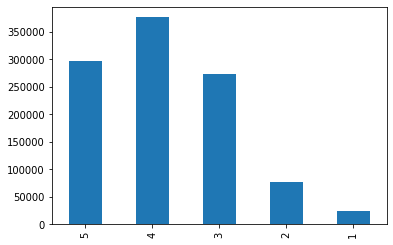

In [8]:
rating_order = [5,4,3,2,1]
ratings_df.rating.value_counts().loc[rating_order].plot(kind='bar', )
plt.show()

We can see that the vast majority of ratings are 3+, with 4 being the most numerous rating.

### Initiating the Surprise library reader and dataset methods

Surprise comes with many familiar built-in datasets, such as Jester and MovieLens, but in this case we will load the book ratings as a custom dataset.

In [9]:
# create a reader that takes the rating scale as a parameter
reader = Reader(rating_scale=(1,5))
# use the load_from_df function to load our book ratings dataframe
data = Dataset.load_from_df(ratings_df[['user_id', 'book_id','rating']], reader)

### Splitting the data

In [11]:
# split data into a training set and a test set with an 80/20 ratio
trainset, testset = train_test_split(data, test_size=0.2)

### Calling the recommender algorithms and training them on the data

As stated in the introduction, we will be using SVD, UBCF, and IBCF algorithms to produce rating predictions. The UBCF and IBCF algorithms we will use will be "with means," meaning that the mean rating of each user or item will be taken into consideration in the form of bias

In [16]:
# setting sim_options for the KNNWithMeans function to distinguish between UBCF and IBCF.
sim_options_ubcf = {'name':'cosine','user_based':True}
sim_option_ibcf = {'name':'cosine','user_based':False}

# assign each algorithm to a variable
algo_svd = SVD()
algo_ubcf = KNNWithMeans(sim_options=sim_options_ubcf)
algo_ibcf = KNNWithMeans(sim_options=sim_option_ibcf)

# train each algorithm with the training set
# we wil use the timeit function to gauge how long each process takes
tic = timeit.default_timer()
algo_svd.fit(trainset)
toc = timeit.default_timer()
tic-toc

-45.31880175900005

In [18]:
tic = timeit.default_timer()
algo_ubcf.fit(trainset)
toc = timeit.default_timer()
tic-toc

Computing the cosine similarity matrix...
Done computing similarity matrix.


-112.837294509

In [19]:
tic = timeit.default_timer()
algo_ibcf.fit(trainset)
toc = timeit.default_timer()
tic-toc

Computing the cosine similarity matrix...
Done computing similarity matrix.


-13.660267449000003

For this dataset, the user-based collaborative filtering algorithm took by far the longest to train, while item-based was the shortest.

### Creating the predictions matrices

We will use the test set to create the predictions matrices while again keeping an eye on the processing time.

In [20]:
tic = timeit.default_timer()
predictions_svd = algo_svd.test(testset)
toc = timeit.default_timer()
tic-toc

-2.4594789050001964

In [21]:
tic = timeit.default_timer()
predictions_ubcf = algo_ubcf.test(testset)
toc = timeit.default_timer()
tic-toc

-139.7342614449999

In [22]:
tic = timeit.default_timer()
predictions_ibcf = algo_ibcf.test(testset)
toc = timeit.default_timer()
tic-toc

-26.726808166999945

In creating the predictions matrix, the SVD algorithm was extremely efficient, taking about 2.5 seconds. Again the UBCF algorithm was slow while the IBCF was significantly faster, but in this case far slower than SVD.

In [23]:
# display the predictions matrices
pd.DataFrame(predictions_svd).head()

,uid,iid,r_ui,est,details
0,6564,82,4.0,3.649587,{'was_impossible': False}
1,7004,2547,5.0,3.932128,{'was_impossible': False}
2,6432,503,4.0,3.659755,{'was_impossible': False}
3,11486,241,5.0,4.218662,{'was_impossible': False}
4,12840,251,5.0,3.978246,{'was_impossible': False}


In [24]:
pd.DataFrame(predictions_ubcf).head()

,uid,iid,r_ui,est,details
0,6564,82,4.0,2.752987,"{'actual_k': 40, 'was_impossible': False}"
1,7004,2547,5.0,4.007065,"{'actual_k': 40, 'was_impossible': False}"
2,6432,503,4.0,3.585745,"{'actual_k': 40, 'was_impossible': False}"
3,11486,241,5.0,3.935059,"{'actual_k': 40, 'was_impossible': False}"
4,12840,251,5.0,3.768193,"{'actual_k': 40, 'was_impossible': False}"


In [25]:
pd.DataFrame(predictions_ibcf).head()

,uid,iid,r_ui,est,details
0,6564,82,4.0,3.049502,"{'actual_k': 5, 'was_impossible': False}"
1,7004,2547,5.0,4.260879,"{'actual_k': 40, 'was_impossible': False}"
2,6432,503,4.0,3.803407,"{'actual_k': 40, 'was_impossible': False}"
3,11486,241,5.0,3.865377,"{'actual_k': 40, 'was_impossible': False}"
4,12840,251,5.0,4.010829,"{'actual_k': 40, 'was_impossible': False}"


### Calculate RMSE for each prediction matrix using the accuracy method

In [26]:
accuracy.rmse(predictions_svd)

RMSE: 0.8683


0.8683405795425959

In [27]:
accuracy.rmse(predictions_ubcf)

RMSE: 0.8955


0.8954841380124771

In [28]:
accuracy.rmse(predictions_ibcf)

RMSE: 0.8826


0.8825989737675298

SVD had the lowest RMSE while UBCF had the highest.

### Implementing support for diversity

Implementing support for diversity using the Surprise library requires writing a custom algorithm. Increased diversity could be achieved by adding some randomness to the prediction algorithm.

In Surprise's prediction algorithm's package the function random_pred.NormalPredictor will predict a rating based on the distribution of the training set. By assigning a certain weight to this prediction, say 10%, and weighting the main algorithm predictions at 90%, we can generate predictions that have increased diversity.

"Accuracy" in terms of RMSE would decrease as a trade-off for more diverse predictions.

### Conclusions

SVD had the highest prediction accuracy in terms of RMSE, and better overall processing time compared to UBCF and IBCF.

Online environments are necessary to gauge real user engagement. Accuracy measures in an offline environment are somewhat meaningless if they do not translate to better user experience. Experiments that ask users to rate the quality of their recommendations, or measures of the level of their engagement (i.e. how quickly they read a recommended book) would go far in determining which algorithm or hybrid algorithm is the most effective.